## **First Test for the subject C10 of the optimisation in data analysis courses**

In [1]:
# Check if cuda is avaible for GPU acceleartion
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use of :", device)

Use of : cuda


### Definition of the algorithm Dual Coordinate Descent with L2-SVM without any optimisation (section 2 of the article)

In [2]:
# Definition of the function

import numpy as np

def dual_coordinate_descent_l2_svm(X, y, C=1.0, tol=1e-3, max_iter=100):
    """
    Dual Coordinate Descent algorithm implementation for L2-SVM
    X : (l x n) feature matrix
    y : (l,) label vector {-1, +1}
    C : regularization parameter
    tol : convergence tolerance
    max_iter : maximum number of outer iterations
    """
    l, n = X.shape
    alpha = np.zeros(l)
    w = np.zeros(n)
    D = 1 / (2 * C)  # L2-SVM => Dii = 1/(2C)

    for it in range(max_iter):
        alpha_old = alpha.copy()

        for i in np.random.permutation(l):  # random permutation
            xi = X[i]
            yi = y[i]

            G = yi * np.dot(w, xi) - 1 + D * alpha[i]

            # Projected gradient
            if alpha[i] == 0 and G >= 0:
                continue
            elif alpha[i] == np.inf and G <= 0:
                continue
            elif 0 < alpha[i] < np.inf and abs(G) < tol:
                continue

            # Update alpha_i
            Qii = np.dot(xi, xi) + D
            alpha_i_old = alpha[i]
            alpha[i] = alpha[i] - G / Qii
            # No upper bound for L2-SVM (U = ∞), but we ensure alpha[i] ≥ 0
            alpha[i] = max(alpha[i], 0)

            # Update w
            w += (alpha[i] - alpha_i_old) * yi * xi

        # Simple stopping criterion (change in alphas)
        diff = np.linalg.norm(alpha - alpha_old)
        if diff < tol:
            print(f"Convergence reached at iteration {it}")
            break

    return w, alpha


#### On a created dataset

In [3]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Generate simple synthetic data
X, y = make_classification(n_samples=100, n_features=10, n_informative=5)
y = 2 * (y - 0.5)  # Convert labels from {0,1} to {-1, +1}

# Standardize features
X = StandardScaler().fit_transform(X)

# Run the algorithm
w, alpha = dual_coordinate_descent_l2_svm(X, y, C=1.0)

# Make predictions
preds = np.sign(X @ w)
accuracy = np.mean(preds == y)
print("Accuracy:", accuracy)

Accuracy: 0.81


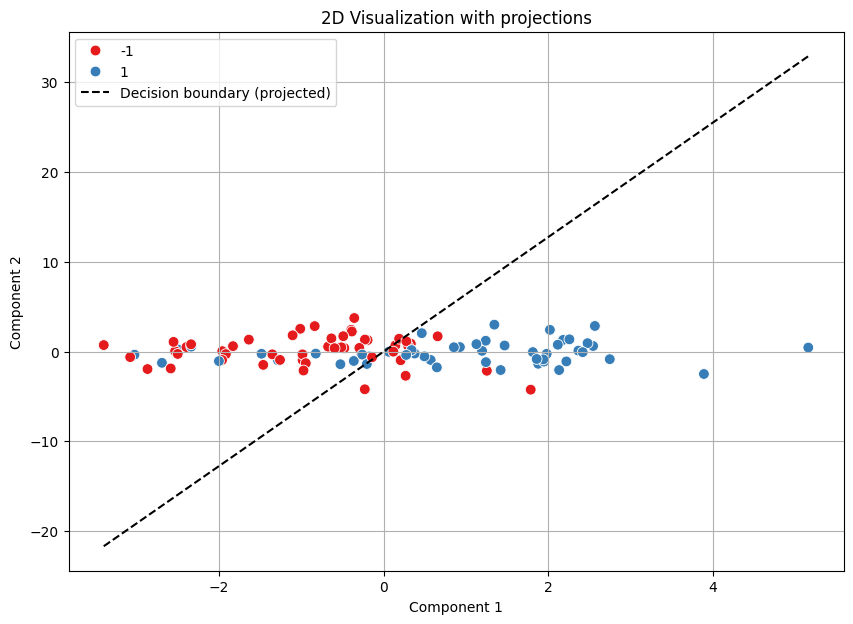

In [4]:
# Visualisation of Dataset + results

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Project the vector w into the reduced (2D) space
w_2d = pca.transform([w])[0]  # projection of w into the same PCA space

# Prepare data for plotting
df = pd.DataFrame({
    'PC1': X_2d[:, 0],
    'PC2': X_2d[:, 1],
    'Label': y.astype(int)
})

# Plot the data points using seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', palette='Set1', s=60)

# Plot the hyperplane: 
slope = -w_2d[0] / w_2d[1] if w_2d[1] != 0 else 0
x_vals = np.linspace(df['PC1'].min(), df['PC1'].max(), 100)
y_vals = slope * x_vals

plt.plot(x_vals, y_vals, '--', color='black', label='Decision boundary (projected)')
plt.title("2D Visualization with projections")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()

#### On a real dataset (Breast Cancer dataset)

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target  # 0 ou 1

# Convert to {-1, +1}
y = 2 * (y - 0.5)

# Standardize features
X = StandardScaler().fit_transform(X)

# Run the algorithm
w, alpha = dual_coordinate_descent_l2_svm(X, y, C=1.0)

# Make predictions
preds = np.sign(X @ w)
accuracy = np.mean(preds == y)
print("Accuracy:", accuracy)

Accuracy: 0.9859402460456942


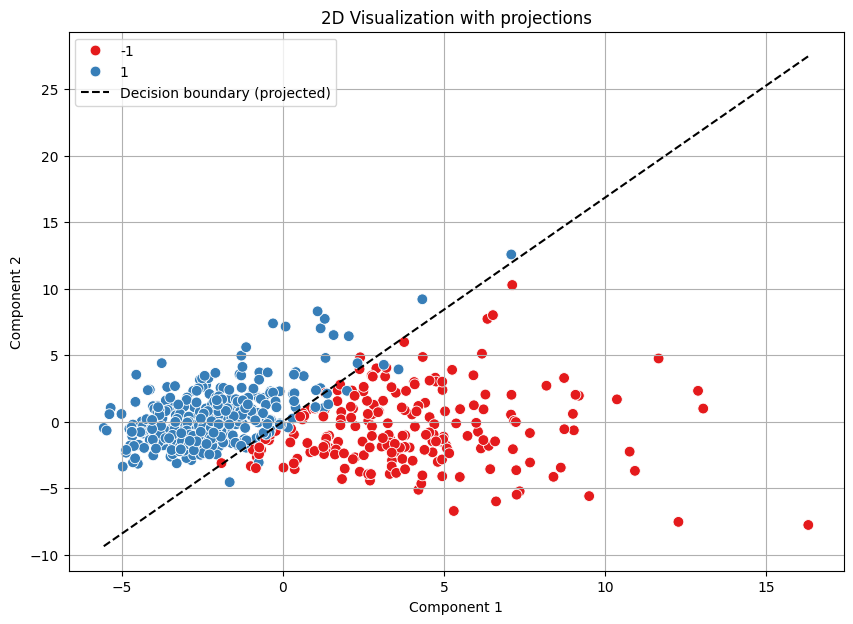

In [6]:
# Visualisation of Dataset + results

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Project the vector w into the reduced (2D) space
w_2d = pca.transform([w])[0]  # projection of w into the same PCA space

# Prepare data for plotting
df = pd.DataFrame({
    'PC1': X_2d[:, 0],
    'PC2': X_2d[:, 1],
    'Label': y.astype(int)
})

# Plot the data points using seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', palette='Set1', s=60)

# Plot the hyperplane: 
slope = -w_2d[0] / w_2d[1] if w_2d[1] != 0 else 0
x_vals = np.linspace(df['PC1'].min(), df['PC1'].max(), 100)
y_vals = slope * x_vals

plt.plot(x_vals, y_vals, '--', color='black', label='Decision boundary (projected)')
plt.title("2D Visualization with projections")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()

### Amelioration of the algorithm Dual Coordinate Descent with L2-SVM (section 3 of the article)

In [7]:
from sklearn.metrics import accuracy_score
import time

# Version with Random Permutation
def dcd_random_perm(X, y, C=1.0, tol=1e-3, max_iter=100):
    l, n = X.shape
    alpha = np.zeros(l)
    w = np.zeros(n)
    D = 1 / (2 * C)

    for it in range(max_iter):
        alpha_old = alpha.copy()
        for i in np.random.permutation(l):
            xi, yi = X[i], y[i]
            G = yi * np.dot(w, xi) - 1 + D * alpha[i]

            if alpha[i] == 0 and G >= 0:
                continue
            elif alpha[i] == np.inf and G <= 0:
                continue
            elif 0 < alpha[i] < np.inf and abs(G) < tol:
                continue

            Qii = np.dot(xi, xi) + D
            alpha_i_old = alpha[i]
            alpha[i] -= G / Qii
            alpha[i] = max(alpha[i], 0)
            w += (alpha[i] - alpha_i_old) * yi * xi

        if np.linalg.norm(alpha - alpha_old) < tol:
            break
    return w, alpha

# Online version: updates a single random alpha at each iteration
def dcd_online(X, y, C=1.0, tol=1e-3, max_iter=10000):
    l, n = X.shape
    alpha = np.zeros(l)
    w = np.zeros(n)
    D = 1 / (2 * C)
    alpha_old = alpha.copy()  # moved outside the loop

    for it in range(max_iter):
        i = np.random.randint(0, l)
        xi, yi = X[i], y[i]
        G = yi * np.dot(w, xi) - 1 + D * alpha[i]

        if alpha[i] == 0 and G >= 0:
            continue
        elif alpha[i] == np.inf and G <= 0:
            continue
        elif 0 < alpha[i] < np.inf and abs(G) < tol:
            continue

        Qii = np.dot(xi, xi) + D
        alpha_i_old = alpha[i]
        alpha[i] -= G / Qii
        alpha[i] = max(alpha[i], 0)
        w += (alpha[i] - alpha_i_old) * yi * xi

        # Check convergence every l iterations
        if it % l == 0:
            if np.linalg.norm(alpha - alpha_old) < tol:
                break
            alpha_old = alpha.copy()

    return w, alpha

def dcd_with_shrinking(X, y, C=1.0, tol=1e-3, max_iter=100):
    l, n = X.shape
    alpha = np.zeros(l)
    w = np.zeros(n)
    D = 1 / (2 * C)
    active_set = np.ones(l, dtype=bool)  # all variables initially active

    for k in range(max_iter):
        alpha_old = alpha.copy()
        G_max = -np.inf
        G_min = np.inf

        for i in np.random.permutation(np.where(active_set)[0]):
            xi, yi = X[i], y[i]
            G = yi * np.dot(w, xi) - 1 + D * alpha[i]

            # Projected gradient
            if alpha[i] == 0 and G >= 0:
                pass
            elif alpha[i] == np.inf and G <= 0:
                pass
            elif 0 < alpha[i] < np.inf and abs(G) < tol:
                pass
            else:
                Qii = np.dot(xi, xi) + D
                alpha_i_old = alpha[i]
                alpha[i] -= G / Qii
                alpha[i] = max(alpha[i], 0)
                w += (alpha[i] - alpha_i_old) * yi * xi

            # Update projected gradient range
            if alpha[i] > 0 and alpha[i] < np.inf:
                G_proj = G
            elif alpha[i] == 0:
                G_proj = min(0, G)
            else:  # alpha[i] == U, which is ∞ here
                G_proj = max(0, G)

            G_max = max(G_max, G_proj)
            G_min = min(G_min, G_proj)

        # Shrinking condition
        G_max_bar = G_max if G_max > 0 else np.inf
        G_min_bar = G_min if G_min < 0 else -np.inf

        for i in range(l):
            if not active_set[i]:
                continue
            xi, yi = X[i], y[i]
            G = yi * np.dot(w, xi) - 1 + D * alpha[i]
            if (alpha[i] == 0 and G > G_max_bar) or (alpha[i] == np.inf and G < G_min_bar):
                active_set[i] = False  # shrink

        # Stopping criterion
        if G_max - G_min < tol:
            print(f"Shrinking convergence at iteration {k}")
            break

        # If we shrank too much, unshrink
        if np.sum(active_set) == 0:
            active_set[:] = True

    return w, alpha



Base - Time: 0.1386s - Accuracy: 0.9877
Random Permutation - Time: 0.2070s - Accuracy: 0.9895
Online - Time: 0.0015s - Accuracy: 0.9350
With Shrinking - Time: 0.1066s - Accuracy: 0.9895


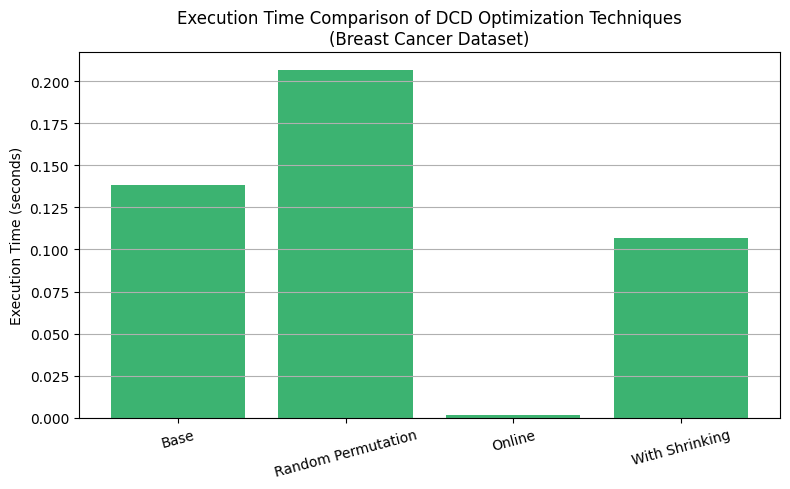

In [8]:
## Test on breast cancer dataset

# Load and preprocess breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target
y = 2 * (y - 0.5)  # Convert to {-1, +1}
X = StandardScaler().fit_transform(X)

# Reference base implementation (fixed order)
def dcd_base(X, y, C=1.0, tol=1e-3, max_iter=100):
    l, n = X.shape
    alpha = np.zeros(l)
    w = np.zeros(n)
    D = 1 / (2 * C)
    for it in range(max_iter):
        alpha_old = alpha.copy()
        for i in range(l):  # fixed order
            xi, yi = X[i], y[i]
            G = yi * np.dot(w, xi) - 1 + D * alpha[i]
            if alpha[i] == 0 and G >= 0:
                continue
            elif alpha[i] == np.inf and G <= 0:
                continue
            elif 0 < alpha[i] < np.inf and abs(G) < tol:
                continue
            Qii = np.dot(xi, xi) + D
            alpha_i_old = alpha[i]
            alpha[i] -= G / Qii
            alpha[i] = max(alpha[i], 0)
            w += (alpha[i] - alpha_i_old) * yi * xi
        if np.linalg.norm(alpha - alpha_old) < tol:
            break
    return w, alpha

# Time each method
methods = {
    "Base": dcd_base,
    "Random Permutation": dcd_random_perm,
    "Online": dcd_online,
    "With Shrinking": dcd_with_shrinking
}

# Store timings and accuracies
timings = {}
accuracies = {}

for name, method in methods.items():
    start = time.time()
    w, alpha = method(X, y, C=1.0, tol=1e-3, max_iter=100)
    elapsed = time.time() - start
    timings[name] = elapsed

    # Accuracy
    y_pred = np.sign(X @ w)
    accuracy = accuracy_score(y, y_pred)
    accuracies[name] = accuracy
    print(f"{name} - Time: {elapsed:.4f}s - Accuracy: {accuracy:.4f}")


# Plot the comparison
plt.figure(figsize=(8, 5))
plt.bar(timings.keys(), timings.values(), color='mediumseagreen')
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time Comparison of DCD Optimization Techniques\n(Breast Cancer Dataset)")
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()